# HW3

## Homework3-1: Data Mining

In [1]:
# %pip install html5lib
# %pip install webdriver-manager
# %pip install selenium

In [1]:
from selenium import webdriver                            
from selenium.webdriver.chrome.service import Service     
from time import sleep                                    
import pandas as pd                                       
from io import StringIO                                  
from functools import partial                             
import matplotlib.pyplot as plt                           
from selenium.webdriver.support import expected_conditions as EC   
from selenium.webdriver.common.by import By               
from selenium.common import NoSuchElementException,StaleElementReferenceException
from matplotlib import style                             
from webdriver_manager.chrome import ChromeDriverManager  
from bs4 import BeautifulSoup
import time

print(plt.style.available)
%matplotlib inline
driver = webdriver.Chrome()

url1='https://zhangjiakou.esf.fang.com/house-a011434/'
driver.get(url1) #使用浏览器打开指定的URL

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Homework3-2: Data Mining

In [3]:
from selenium import webdriver                            
from selenium.webdriver.chrome.service import Service     
from selenium.webdriver.common.by import By               
from selenium.common import NoSuchElementException, StaleElementReferenceException
from selenium.webdriver.support import expected_conditions as EC   
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd                                       
import time
from bs4 import BeautifulSoup
import re

# 初始化浏览器
driver = webdriver.Chrome()
url1 = 'https://zhangjiakou.esf.fang.com/house-a011434/'
driver.get(url1)

# 等待页面加载
wait = WebDriverWait(driver, 10)
time.sleep(3)

# 爬取多页数据
string_list = []
i = 0
Num_Pages = 50

while i < Num_Pages:
    try:
        # 使用显式等待确保元素加载完成
        table = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'shop_list')))
        html_content = table.get_attribute('outerHTML')
        string_list.append(html_content)
        print(f"成功获取第 {i+1} 页数据")
        
        # 查找下一页按钮
        try:
            next_page = driver.find_element(By.CLASS_NAME, 'last')
            next_page.click()
            i += 1
            # 等待新页面加载
            time.sleep(3)
        except NoSuchElementException:
            print("找不到下一页按钮，可能已是最后一页")
            break
    except Exception as e:
        print(f"第 {i+1} 页处理出错: {e}")
        break

# 解析房源数据
all_data = []

for page_num, html in enumerate(string_list, 1):
    soup = BeautifulSoup(html, 'html.parser')
    property_items = soup.find_all('dl', class_='clearfix')
    
    print(f"正在解析第 {page_num} 页，共 {len(property_items)} 条房源")
    
    for item in property_items:
        row_data = {}
        
        # 1. 提取房源ID和类型
        data_bg = item.get('data-bg', '')
        if data_bg:
            try:
                import json
                data_dict = json.loads(data_bg.replace("'", '"'))
                row_data['房源ID'] = data_dict.get('houseid', '')
                row_data['房源类型'] = data_dict.get('housetype', '')
                row_data['经纪人ID'] = data_dict.get('agentid', '')
            except:
                row_data['房源ID'] = data_bg
        
        # 2. 提取标题和链接
        title_link = item.find('a', title=True)
        if title_link:
            row_data['标题'] = title_link.get('title', '')
            href = title_link.get('href', '')
            if href and href.startswith('/'):
                row_data['链接'] = "https://zhangjiakou.esf.fang.com" + href
            else:
                row_data['链接'] = href
        
        # 3. 提取图片
        img = item.find('img')
        if img:
            # 优先使用data-src，如果没有则用src
            row_data['图片'] = img.get('data-src', img.get('src', ''))
        
        # 4. 提取标签（热搜、人气等）
        tags = []
        tag_spans = item.find_all('span', class_=lambda x: x and x.startswith('bg_'))
        for tag_span in tag_spans:
            tags.append(tag_span.get_text(strip=True))
        if tags:
            row_data['标签'] = ', '.join(tags)
        
        # 5. 提取详细标题
        title_span = item.find('span', class_='tit_shop')
        if title_span:
            row_data['详细标题'] = title_span.get_text(strip=True)
        
        # 6. 提取房屋基本信息
        tel_shop = item.find('p', class_='tel_shop')
        if tel_shop:
            tel_text = tel_shop.get_text(strip=True)
            # 使用正则表达式提取关键信息
            # 提取户型
            room_match = re.search(r'(\d+室\d+厅)', tel_text)
            if room_match:
                row_data['户型'] = room_match.group(1)
            # 提取面积
            area_match = re.search(r'(\d+\.?\d*)㎡', tel_text)
            if area_match:
                row_data['面积'] = area_match.group(1) + '㎡'
            # 提取楼层信息
            floor_match = re.search(r'([高|中|低|顶]层)（共(\d+)层）', tel_text)
            if floor_match:
                row_data['楼层'] = floor_match.group(1)
                row_data['总楼层'] = floor_match.group(2) + '层'
            # 提取朝向
            direction_match = re.search(r'([东西南北]+向)', tel_text)
            if direction_match:
                row_data['朝向'] = direction_match.group(1)
            # 提取建成年份
            year_match = re.search(r'(\d{4})年建', tel_text)
            if year_match:
                row_data['建成年份'] = year_match.group(1) + '年'
            # 提取经纪人
            agent_link = tel_shop.find('a')
            if agent_link:
                row_data['经纪人'] = agent_link.get_text(strip=True)
        
        # 7. 提取地址信息
        add_shop = item.find('p', class_='add_shop')
        if add_shop:
            # 小区名称
            community_link = add_shop.find('a')
            if community_link:
                row_data['小区名称'] = community_link.get('title', '') or community_link.get_text(strip=True)
            # 地址
            address_span = add_shop.find('span')
            if address_span:
                row_data['地址'] = address_span.get_text(strip=True)
        
        # 8. 提取房产标签（满二、满五唯一等）
        label_link = item.find('p', class_='label').find('a') if item.find('p', class_='label') else None
        if label_link:
            row_data['房产标签'] = label_link.get_text(strip=True)
        
        # 9. 提取价格信息
        price_right = item.find('dd', class_='price_right')
        if price_right:
            # 总价
            total_price_span = price_right.find('span', class_='red')
            if total_price_span:
                row_data['总价'] = total_price_span.get_text(strip=True)
            # 单价
            unit_price_spans = price_right.find_all('span')
            if len(unit_price_spans) > 1:
                row_data['单价'] = unit_price_spans[1].get_text(strip=True)
        all_data.append(row_data)

# 创建DataFrame
if all_data:
    df_full = pd.DataFrame(all_data)
    
    # 打印结果统计
    print(f"\n成功提取 {len(df_full)} 条房源信息")
    print("\n数据列名:")
    print(df_full.columns.tolist())
    print("\n数据预览:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', 50)
    print(df_full.head(10))
    
    # 保存到CSV文件
    df_full.to_csv('huailai_housing_price_1.csv', index=False, encoding='utf-8-sig')
    print(f"\n数据已保存到 huailai_housing_price_1.csv，共 {len(df_full)} 条记录")
    
    # 显示数据统计信息
    print("\n数据统计:")
    print(f"价格范围: {df_full['总价'].min()} - {df_full['总价'].max()}")
    if '面积' in df_full.columns:
        area_series = df_full['面积'].dropna()
        if not area_series.empty:
            print(f"面积范围: {area_series.min()} - {area_series.max()}")
else:
    print("没有提取到房源数据")

# 关闭浏览器
driver.quit()

成功获取第 1 页数据
成功获取第 2 页数据
成功获取第 3 页数据
成功获取第 4 页数据
成功获取第 5 页数据
成功获取第 6 页数据
成功获取第 7 页数据
成功获取第 8 页数据
成功获取第 9 页数据
成功获取第 10 页数据
成功获取第 11 页数据
成功获取第 12 页数据
成功获取第 13 页数据
成功获取第 14 页数据
成功获取第 15 页数据
成功获取第 16 页数据
成功获取第 17 页数据
成功获取第 18 页数据
成功获取第 19 页数据
成功获取第 20 页数据
成功获取第 21 页数据
成功获取第 22 页数据
成功获取第 23 页数据
成功获取第 24 页数据
成功获取第 25 页数据
成功获取第 26 页数据
成功获取第 27 页数据
成功获取第 28 页数据
成功获取第 29 页数据
成功获取第 30 页数据
成功获取第 31 页数据
成功获取第 32 页数据
成功获取第 33 页数据
成功获取第 34 页数据
成功获取第 35 页数据
成功获取第 36 页数据
成功获取第 37 页数据
成功获取第 38 页数据
成功获取第 39 页数据
成功获取第 40 页数据
成功获取第 41 页数据
成功获取第 42 页数据
成功获取第 43 页数据
成功获取第 44 页数据
成功获取第 45 页数据
成功获取第 46 页数据
成功获取第 47 页数据
成功获取第 48 页数据
成功获取第 49 页数据
成功获取第 50 页数据
正在解析第 1 页，共 60 条房源
正在解析第 2 页，共 60 条房源
正在解析第 3 页，共 60 条房源
正在解析第 4 页，共 60 条房源
正在解析第 5 页，共 60 条房源
正在解析第 6 页，共 60 条房源
正在解析第 7 页，共 60 条房源
正在解析第 8 页，共 60 条房源
正在解析第 9 页，共 60 条房源
正在解析第 10 页，共 60 条房源
正在解析第 11 页，共 60 条房源
正在解析第 12 页，共 60 条房源
正在解析第 13 页，共 60 条房源
正在解析第 14 页，共 60 条房源
正在解析第 15 页，共 60 条房源
正在解析第 16 页，共 60 条房源
正在解析第 17 页，共 60 条房源
正在解析第 18 页，共 60 条房源
正在解析第 19

In [4]:
import pandas as pd
# 读取原始数据
df = pd.read_csv('huailai_housing_price_1.csv')
# 选择需要的列并重命名
df_processed = df[['面积', '地址', '总价', '单价']].copy()
df_processed.columns = ['m2', 'location', 'price', 'price_per_m2']
# 将所有location内容替换为"怀来"
df_processed['location'] = '怀来'
# 保存处理后的数据
df_processed.to_csv('huailai_housing_price.csv', index=False, encoding='utf-8-sig')
# 显示处理后的数据预览
print("处理后的数据预览:")
print(df_processed.head(10))
print(f"\n数据形状: {df_processed.shape}")
print(f"保存成功: huailai_housing_price.csv，共 {len(df_processed)} 条记录")

处理后的数据预览:
        m2 location price price_per_m2
0      78㎡       怀来   55万      7051元/㎡
1     118㎡       怀来   45万      3813元/㎡
2     110㎡       怀来  110万     10000元/㎡
3      49㎡       怀来   15万      3061元/㎡
4     105㎡       怀来   86万      8190元/㎡
5     124㎡       怀来   80万      6451元/㎡
6  121.05㎡       怀来   68万      5617元/㎡
7     168㎡       怀来  170万     10119元/㎡
8   83.36㎡       怀来   33万      3958元/㎡
9  123.93㎡       怀来  147万     11861元/㎡

数据形状: (2895, 4)
保存成功: huailai_housing_price.csv，共 2895 条记录


In [5]:
#清理单位
import pandas as pd
df = pd.read_csv('huailai_housing_price.csv')
# 直接使用字符串替换方法去除单位
df['m2'] = df['m2'].str.replace('㎡', '', regex=False)
df['price'] = df['price'].str.replace('万', '', regex=False)
df['price_per_m2'] = df['price_per_m2'].str.replace('元/㎡', '', regex=False)
# 转换为数值类型
df['m2'] = pd.to_numeric(df['m2'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price_per_m2'] = pd.to_numeric(df['price_per_m2'], errors='coerce')
# 保存处理后的数据
df.to_csv('huailai_housing_price.csv', index=False, encoding='utf-8-sig')
# 显示处理结果
print("处理后的数据预览:")
print(df.head(10))
print(f"数据形状: {df.shape}")
print(f"price_per_m2列的非空值数量: {df['price_per_m2'].notna().sum()}")
print("保存成功: huailai_housing_price.csv")

处理后的数据预览:
       m2 location  price  price_per_m2
0   78.00       怀来   55.0          7051
1  118.00       怀来   45.0          3813
2  110.00       怀来  110.0         10000
3   49.00       怀来   15.0          3061
4  105.00       怀来   86.0          8190
5  124.00       怀来   80.0          6451
6  121.05       怀来   68.0          5617
7  168.00       怀来  170.0         10119
8   83.36       怀来   33.0          3958
9  123.93       怀来  147.0         11861
数据形状: (2895, 4)
price_per_m2列的非空值数量: 2895
保存成功: huailai_housing_price.csv


In [6]:
from selenium import webdriver                            
from selenium.webdriver.chrome.service import Service     
from selenium.webdriver.common.by import By               
from selenium.common import NoSuchElementException, StaleElementReferenceException
from selenium.webdriver.support import expected_conditions as EC   
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd                                       
import time
from bs4 import BeautifulSoup
import re
import os

# 初始化浏览器
driver = webdriver.Chrome()
url12 = 'https://zhangjiakou.zu.fang.com/house-a011434/'
driver.get(url12)
# 等待页面加载
time.sleep(5)
# 保存页面源代码用于详细分析
page_source = driver.page_source
with open('rent_page_full_source.html', 'w', encoding='utf-8') as f:
    f.write(page_source)
print("已保存完整页面源代码")
# 使用BeautifulSoup深度分析页面结构
soup = BeautifulSoup(page_source, 'html.parser')
# 分析页面结构
print("="*50)
print("页面结构分析:")
print("="*50)

# 1. 查找所有可能的列表容器
list_containers = soup.find_all(class_=re.compile(r'list|shop|house|item'))
print(f"找到 {len(list_containers)} 个可能的列表容器")

for i, container in enumerate(list_containers[:5]):  # 只显示前5个
    classes = container.get('class', [])
    print(f"容器 {i+1}: 类名={classes}, 标签={container.name}")

# 2. 查找所有可能的房源项
print("\n" + "="*50)
print("房源项分析:")
print("="*50)

# 尝试多种可能的房源项选择器
item_selectors = [
    'dl',
    'div[class*="item"]',
    'li[class*="item"]',
    '.house-list-item',
    '.zufang-item',
    '.list-item',
    '.shop-list-item'
]

all_items = []
for selector in item_selectors:
    items = soup.select(selector)
    if items:
        print(f"选择器 '{selector}' 找到 {len(items)} 个项")
        all_items.extend(items)

# 去重
unique_items = []
seen_ids = set()
for item in all_items:
    item_id = str(item)
    if item_id not in seen_ids:
        seen_ids.add(item_id)
        unique_items.append(item)
print(f"总共找到 {len(unique_items)} 个唯一的房源项")

# 3. 详细分析前3个房源项的结构
print("\n" + "="*50)
print("前3个房源项的详细结构:")
print("="*50)
for i, item in enumerate(unique_items[:3]):
    print(f"\n--- 房源项 {i+1} ---")
    print(f"标签: {item.name}")
    print(f"类名: {item.get('class', [])}")
    print(f"ID: {item.get('id', '无')}")
    # 打印所有直接子元素
    print("直接子元素:")
    for child in item.children:
        if child.name:
            print(f"  - {child.name}: 类名={child.get('class', [])}")
    # 查找价格相关信息
    price_elements = item.find_all(text=re.compile(r'[0-9]+元|[0-9]+万|价格|租金|月租'))
    if price_elements:
        print("价格相关文本:")
        for price in price_elements:
            print(f"  - {price.strip()}")
    # 查找标题和链接
    links = item.find_all('a', href=True)
    if links:
        print("链接:")
        for link in links:
            title = link.get('title', '') or link.get_text(strip=True)
            print(f"  - 标题: {title[:50]}...")
            print(f"    链接: {link['href']}")
    # 打印完整的HTML结构
    print("完整HTML结构:")
    print(item.prettify()[:1000] + "..." if len(item.prettify()) > 1000 else item.prettify())

# 基于分析结果，创建灵活的数据提取函数
def extract_rental_data(soup):
    """根据页面结构灵活提取租房数据"""
    data = []
    # 尝试多种可能的房源项选择器
    item_selectors = [
        'dl',
        'div[class*="item"]',
        'li[class*="item"]',
        '.house-list-item',
        '.zufang-item',
        '.list-item',
        '.shop-list-item'
    ]
    items = []
    for selector in item_selectors:
        found_items = soup.select(selector)
        if found_items:
            items.extend(found_items)
            print(f"使用选择器 '{selector}' 找到 {len(found_items)} 个房源项")
    # 去重
    seen = set()
    unique_items = []
    for item in items:
        item_str = str(item)
        if item_str not in seen:
            seen.add(item_str)
            unique_items.append(item)
    print(f"总共处理 {len(unique_items)} 个唯一房源项")
    
    for item in unique_items:
        row = {}
        
        # 提取标题
        title_elem = item.find(['a', 'h3', 'h4', 'span'], string=re.compile(r'.+'))
        if title_elem:
            row['标题'] = title_elem.get_text(strip=True)
        
        # 提取链接
        link_elem = item.find('a', href=True)
        if link_elem:
            href = link_elem['href']
            if href.startswith('/'):
                row['链接'] = 'https://zhangjiakou.zu.fang.com' + href
            else:
                row['链接'] = href
        
        # 提取价格 - 使用多种方法
        # 方法1: 查找包含"元"或"万"的文本
        price_text = item.find(text=re.compile(r'[0-9]+\.?[0-9]*\s*(元|万)'))
        if price_text:
            row['价格'] = price_text.strip()
        # 方法2: 查找包含价格类名的元素
        price_elem = item.find(class_=re.compile(r'price|money|cost|rent'))
        if price_elem:
            row['价格'] = price_elem.get_text(strip=True)
        # 提取面积
        area_match = re.search(r'(\d+\.?\d*)\s*㎡', item.get_text())
        if area_match:
            row['面积'] = area_match.group(1) + '㎡'
        # 提取地址/位置
        address_elem = item.find(class_=re.compile(r'add|address|location|area'))
        if address_elem:
            row['地址'] = address_elem.get_text(strip=True)
        # 提取户型
        room_match = re.search(r'(\d+室\d*厅*)', item.get_text())
        if room_match:
            row['户型'] = room_match.group(1)
        # 保存完整文本作为备用
        row['完整文本'] = item.get_text(separator=' | ', strip=True)
        # 只添加有数据的行
        if any(row.values()):
            data.append(row)
    return data

# 爬取多页数据
all_rental_data = []
max_pages = 3

for page_num in range(max_pages):
    print(f"\n正在处理第 {page_num+1} 页...")
    # 获取当前页面源代码
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    # 提取数据
    page_data = extract_rental_data(soup)
    all_rental_data.extend(page_data)
    print(f"第 {page_num+1} 页提取到 {len(page_data)} 条租房信息")
    
    # 尝试找到并点击下一页
    next_found = False
    next_selectors = [
        'a.next',
        'a[class*="next"]',
        '.page-next',
        'a:contains("下一页")',
        'a:contains(">")'
    ]
    
    for selector in next_selectors:
        try:
            if 'contains' in selector:
                # 使用XPath查找包含特定文本的链接
                text = selector.split('"')[1]
                next_button = driver.find_element(By.XPATH, f'//a[contains(text(), "{text}")]')
            else:
                next_button = driver.find_element(By.CSS_SELECTOR, selector)
            
            if next_button.is_displayed() and next_button.is_enabled():
                driver.execute_script("arguments[0].click();", next_button)
                next_found = True
                time.sleep(3)  # 等待页面加载
                break
        except Exception as e:
            continue
    
    if not next_found:
        print("找不到下一页按钮，停止爬取")
        break

# 创建DataFrame并保存
if all_rental_data:
    df = pd.DataFrame(all_rental_data)
    # 打印结果
    print(f"\n总共提取到 {len(df)} 条租房信息")
    print("\n数据列名:")
    print(df.columns.tolist())
    print("\n数据预览:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', 50)
    print(df.head(10))
    # 保存到CSV文件
    df.to_csv('huailai_rent_price_1.csv', index=False, encoding='utf-8-sig')
    print(f"\n数据已保存到 huailai_rent_price_1.csv")
    # 显示统计信息
    if '价格' in df.columns:
        print(f"\n价格统计:")
        print(df['价格'].value_counts().head(10))
else:
    print("没有提取到任何租房数据")

# 关闭浏览器
driver.quit()
print("\n调试完成!")
print("请检查以下文件:")
print("1. rent_page_full_source.html - 完整的页面源代码")
print("2. huailai_rental_data.csv - 提取的租房数据")

已保存完整页面源代码
页面结构分析:
找到 90 个可能的列表容器
容器 1: 类名=['listBox'], 标签=div
容器 2: 类名=['listBox'], 标签=div
容器 3: 类名=['listBox'], 标签=div
容器 4: 类名=['listBox'], 标签=div
容器 5: 类名=['listBox'], 标签=div

房源项分析:
选择器 'dl' 找到 71 个项
选择器 'div[class*="item"]' 找到 1 个项
总共找到 72 个唯一的房源项

前3个房源项的详细结构:

--- 房源项 1 ---
标签: dl
类名: ['search-list', 'clearfix']
ID: rentid_D04_01
直接子元素:
  - dt: 类名=[]
  - dd: 类名=[]
链接:
  - 标题: 不限...
    链接: /house/
  - 标题: 桥东...
    链接: /house-a014961/
  - 标题: 桥西...
    链接: /house-a014962/
  - 标题: 经济开发区...
    链接: /house-a014964/
  - 标题: 下花园...
    链接: /house-a014963/
  - 标题: 宣化...
    链接: /house-a011423/
  - 标题: 张北...
    链接: /house-a011426/
  - 标题: 沽源...
    链接: /house-a011428/
  - 标题: 康保...
    链接: /house-a011427/
  - 标题: 尚义...
    链接: /house-a011429/
  - 标题: 蔚县...
    链接: /house-a011430/
  - 标题: 阳原...
    链接: /house-a011431/
  - 标题: 怀安...
    链接: /house-a011432/
  - 标题: 万全...
    链接: /house-a011433/
  - 标题: 怀来...
    链接: /house-a011434/
  - 标题: 涿鹿...
    链接: /house-a011435/
  - 标题: 赤城...
   

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13980\2565547592.py:87: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  price_elements = item.find_all(text=re.compile(r'[0-9]+元|[0-9]+万|价格|租金|月租'))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13980\2565547592.py:153: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  price_text = item.find(text=re.compile(r'[0-9]+\.?[0-9]*\s*(元|万)'))


使用选择器 'dl' 找到 71 个房源项
使用选择器 'div[class*="item"]' 找到 1 个房源项
总共处理 72 个唯一房源项
第 1 页提取到 71 条租房信息

正在处理第 2 页...
使用选择器 'dl' 找到 26 个房源项
使用选择器 'div[class*="item"]' 找到 1 个房源项
总共处理 27 个唯一房源项
第 2 页提取到 26 条租房信息
找不到下一页按钮，停止爬取

总共提取到 97 条租房信息

数据列名:
['标题', '链接', '完整文本', '价格', '面积', '户型']

数据预览:
                   标题                                                 链接                                               完整文本      价格    面积    户型
0                  不限             https://zhangjiakou.zu.fang.com/house/  区域： | 不限 | 桥东 | 桥西 | 经济开发区 | 下花园 | 宣化 | 张北 | 沽...     NaN   NaN   NaN
1                  不限     https://zhangjiakou.zu.fang.com/house-a011434/  租金： | 不限 | 300元以下 | 300-500元 | 500-800元 | 800-...  300元以下   NaN   NaN
2                  不限     https://zhangjiakou.zu.fang.com/house-a011434/                户型： | 不限 | 一居 | 二居 | 三居 | 四居 | 四居以上     NaN   NaN   NaN
3                  不限     https://zhangjiakou.zu.fang.com/house-a011434/                                 方式： | 不限 | 整租 | 合租     NaN   NaN   NaN

In [7]:
import pandas as pd
import re
# 读取原始数据
df = pd.read_csv('huailai_rent_price_1.csv')
# 选择需要的列并重命名
df_processed = df[['面积', '完整文本', '价格']].copy()
df_processed.columns = ['m2', 'location', 'price']
# 将所有location内容替换为"怀来"
df_processed['location'] = '怀来'
# 数据清洗和单价计算
def extract_number(text):
    """从文本中提取数字"""
    if pd.isna(text):
        return None
    # 将文本转换为字符串，然后提取数字
    text_str = str(text)
    match = re.search(r'(\d+\.?\d*)', text_str)
    return float(match.group(1)) if match else None

# 提取面积数字（去掉㎡）
df_processed['m2_number'] = df_processed['m2'].apply(extract_number)
# 提取价格数字（去掉"元/月"等文本）
df_processed['price_number'] = df_processed['price'].apply(extract_number)
# 计算单价（元/平方米）
df_processed['price_per_m2'] = df_processed.apply(
    lambda row: round(row['price_number'] / row['m2_number'], 2) 
    if (row['price_number'] is not None and row['m2_number'] is not None and row['m2_number'] > 0) 
    else None, 
    axis=1
)

# 只保留需要的列
df_final = df_processed[['m2', 'location', 'price', 'price_per_m2']]
# 保存处理后的数据
df_final.to_csv('huailai_rent_price.csv', index=False, encoding='utf-8-sig')
# 显示处理后的数据预览
print("处理后的数据预览:")
print(df_final.head(10))
print(f"\n数据形状: {df_final.shape}")
print(f"保存成功: huailai_rent_price.csv，共 {len(df_final)} 条记录")

# 显示统计信息 - 使用数字列进行统计
print("\n数据统计:")
if 'price_number' in df_processed.columns:
    valid_prices = df_processed['price_number'].dropna()
    if not valid_prices.empty:
        print(f"价格范围: {valid_prices.min():.0f} - {valid_prices.max():.0f} 元/月")
if 'm2_number' in df_processed.columns:
    valid_areas = df_processed['m2_number'].dropna()
    if not valid_areas.empty:
        print(f"面积范围: {valid_areas.min():.0f} - {valid_areas.max():.0f} ㎡")
if 'price_per_m2' in df_final.columns:
    valid_prices_per_m2 = df_final['price_per_m2'].dropna()
    if not valid_prices_per_m2.empty:
        print(f"单价范围: {valid_prices_per_m2.min():.2f} - {valid_prices_per_m2.max():.2f} 元/㎡")

# 显示有效数据数量
print(f"\n有效数据统计:")
print(f"有效价格记录: {len(valid_prices)} 条")
print(f"有效面积记录: {len(valid_areas)} 条")
print(f"有效单价记录: {len(valid_prices_per_m2)} 条")

处理后的数据预览:
     m2 location   price  price_per_m2
0   NaN       怀来     NaN           NaN
1   NaN       怀来  300元以下           NaN
2   NaN       怀来     NaN           NaN
3   NaN       怀来     NaN           NaN
4   NaN       怀来     NaN           NaN
5   NaN       怀来     NaN           NaN
6   NaN       怀来     NaN           NaN
7   40㎡       怀来     950         23.75
8  104㎡       怀来    1000          9.62
9   73㎡       怀来    1500         20.55

数据形状: (97, 4)
保存成功: huailai_rent_price.csv，共 97 条记录

数据统计:
价格范围: 300 - 15000 元/月
面积范围: 35 - 380 ㎡
单价范围: 6.42 - 47.41 元/㎡

有效数据统计:
有效价格记录: 77 条
有效面积记录: 75 条
有效单价记录: 75 条


In [8]:
#清理单位
import pandas as pd
df = pd.read_csv('huailai_rent_price.csv')
# 直接使用字符串替换方法去除单位
df['m2'] = df['m2'].str.replace('㎡', '', regex=False)
# 转换为数值类型
df['m2'] = pd.to_numeric(df['m2'], errors='coerce')
# 保存处理后的数据
df.to_csv('huailai_rent_price.csv', index=False, encoding='utf-8-sig')
# 显示处理结果
print("处理后的数据预览:")
print(df.head(10))
print(f"数据形状: {df.shape}")
print(f"price_per_m2列的非空值数量: {df['price_per_m2'].notna().sum()}")
print("保存成功: huailai_housing_price.csv")

处理后的数据预览:
      m2 location   price  price_per_m2
0    NaN       怀来     NaN           NaN
1    NaN       怀来  300元以下           NaN
2    NaN       怀来     NaN           NaN
3    NaN       怀来     NaN           NaN
4    NaN       怀来     NaN           NaN
5    NaN       怀来     NaN           NaN
6    NaN       怀来     NaN           NaN
7   40.0       怀来     950         23.75
8  104.0       怀来    1000          9.62
9   73.0       怀来    1500         20.55
数据形状: (97, 4)
price_per_m2列的非空值数量: 75
保存成功: huailai_housing_price.csv


In [10]:
# 处理异常值：跑两次
import pandas as pd
df = pd.read_csv('huailai_rent_price.csv')
print(f"原始数据行数: {len(df)}")
# 删除所有包含空值的行
df_clean = df.dropna()
print(f"清理后数据行数: {len(df_clean)}")
print(df.head(10))
df_clean.to_csv('huailai_rent_price.csv', index=False, encoding='utf-8-sig')
print("清理完成，已保存为 huailai_rent_price.csv")

原始数据行数: 75
清理后数据行数: 75
      m2 location  price  price_per_m2
0   40.0       怀来    950         23.75
1  104.0       怀来   1000          9.62
2   73.0       怀来   1500         20.55
3  107.0       怀来   1600         14.95
4  107.0       怀来   1300         12.15
5  164.0       怀来   3000         18.29
6   35.0       怀来    550         15.71
7  110.0       怀来   4500         40.91
8  109.0       怀来    700          6.42
9  380.0       怀来  12500         32.89
清理完成，已保存为 huailai_rent_price.csv


## Homework3-3: Data Research (仅自己数据)

房价数据基本信息:
数据行数: 2895
数据列数: 4

租金数据基本信息:
数据行数: 75
数据列数: 4

房价数据描述:
                m2        price  price_per_m2
count  2895.000000  2895.000000   2895.000000
mean    122.970542   108.403385   7541.680484
std      77.332318   123.090067   4262.646917
min      33.000000     8.500000   2000.000000
25%      78.480000    37.000000   4553.000000
50%     102.000000    59.000000   6262.000000
75%     140.000000   138.000000   9457.500000
max     800.000000  1500.000000  36505.000000

租金数据描述:
               m2         price  price_per_m2
count   75.000000     75.000000     75.000000
mean   101.146667   1949.786667     17.060667
std     64.101207   2547.220729      8.116099
min     35.000000    550.000000      6.420000
25%     76.000000    975.000000     11.425000
50%     85.000000   1200.000000     15.220000
75%    107.500000   1500.000000     19.050000
max    380.000000  15000.000000     47.410000

房价单价异常值数量: 109
房价面积异常值数量: 224
租金单价异常值数量: 6
租金面积异常值数量: 9

房价中位数: 6262.00 元/㎡
租金中位数: 15.22 元/㎡/月
房

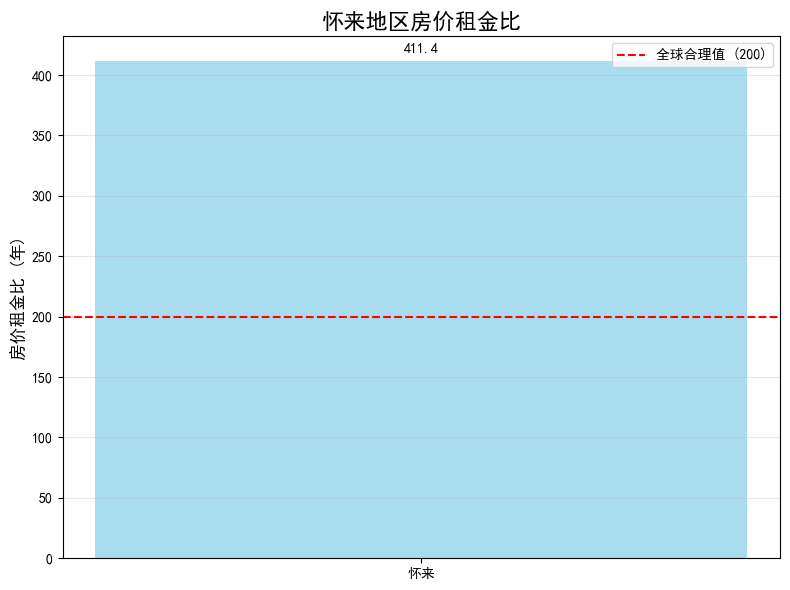


数据分析完成!
房价租金比图表已保存为 'price_to_rent_ratio.png'
合并数据已保存为 'combined_housing_rent_data.csv'


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取并合并数据
housing_df = pd.read_csv('huailai_housing_price.csv')
rent_df = pd.read_csv('huailai_rent_price.csv')
print("房价数据基本信息:")
print(f"数据行数: {len(housing_df)}")
print(f"数据列数: {len(housing_df.columns)}")
print("\n租金数据基本信息:")
print(f"数据行数: {len(rent_df)}")
print(f"数据列数: {len(rent_df.columns)}")

# 2. 数据描述和异常值检测
print("\n房价数据描述:")
print(housing_df.describe())
print("\n租金数据描述:")
print(rent_df.describe())

# 检查异常值 - 使用箱线图方法
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# 检测房价数据的异常值
housing_outliers_price = detect_outliers_iqr(housing_df, 'price_per_m2')
housing_outliers_m2 = detect_outliers_iqr(housing_df, 'm2')
print(f"\n房价单价异常值数量: {len(housing_outliers_price)}")
print(f"房价面积异常值数量: {len(housing_outliers_m2)}")

# 检测租金数据的异常值
rent_outliers_price = detect_outliers_iqr(rent_df, 'price_per_m2')
rent_outliers_m2 = detect_outliers_iqr(rent_df, 'm2')
print(f"租金单价异常值数量: {len(rent_outliers_price)}")
print(f"租金面积异常值数量: {len(rent_outliers_m2)}")

# 3. 计算房价租金比
# 计算中位数
median_housing_price = housing_df['price_per_m2'].median()
median_rent_price = rent_df['price_per_m2'].median()
price_to_rent_ratio = median_housing_price / (median_rent_price)
print(f"\n房价中位数: {median_housing_price:.2f} 元/㎡")
print(f"租金中位数: {median_rent_price:.2f} 元/㎡/月")
print(f"房价租金比: {price_to_rent_ratio:.2f} (年)")

# 4. 绘制房价租金比柱状图
fig, ax = plt.subplots(figsize=(8, 6))
# 创建柱状图
bars = ax.bar(['怀来'], [price_to_rent_ratio], color='skyblue', alpha=0.7)
# 添加全球合理值参考线
ax.axhline(y=200, color='r', linestyle='--', label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom')
# 设置图表标题和标签
ax.set_title('怀来地区房价租金比', fontsize=16, fontweight='bold')
ax.set_ylabel('房价租金比 (年)', fontsize=12)
ax.legend()
# 添加网格
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('price_to_rent_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. 保存分析结果
housing_df['type'] = 'sale'
rent_df['type'] = 'rent'
# 合并数据
combined_df = pd.concat([housing_df, rent_df], ignore_index=True)
# 保存合并后的数据
combined_df.to_csv('combined_housing_rent_data.csv', index=False, encoding='utf-8-sig')

print("\n数据分析完成!")
print(f"房价租金比图表已保存为 'price_to_rent_ratio.png'")
print(f"合并数据已保存为 'combined_housing_rent_data.csv'")

## HW3-4: Data Modeling （怀来单地区）

各区块房价租金比中位数:
location
怀来    408.619123
Name: price_to_rent_ratio, dtype: float64


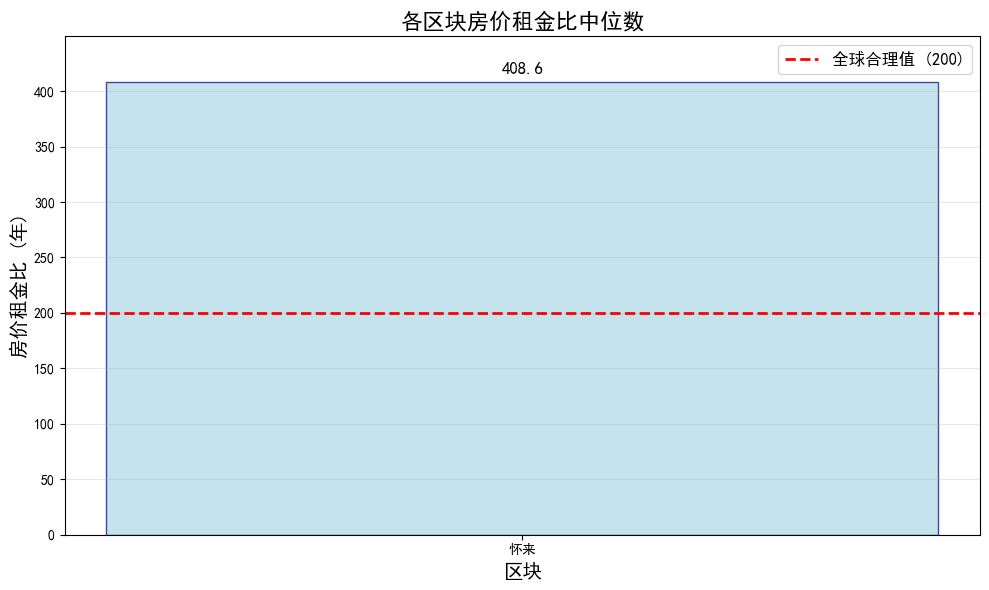


房价模型 R²: 0.2260
房价模型系数: [26.20602746  0.        ]
房价模型截距: 4319.11

租金模型 R²: 0.1906
租金模型系数: [0.05527006 0.        ]
租金模型截距: 11.47

分析完成!
图表已保存为 'median_price_to_rent_ratio_by_block.png'
预测结果已保存为 'predicted_price_rent_ratios.csv'


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取数据
housing_df = pd.read_csv('huailai_housing_price.csv')
rent_df = pd.read_csv('huailai_rent_price.csv')

# 2. 准备数据用于建模
X_house = housing_df[['m2']].copy()
# 添加location编码（虽然只有怀来一个值，但为了模型完整性）
le = LabelEncoder()
X_house['location_encoded'] = le.fit_transform(housing_df['location'])
y_house = housing_df['price_per_m2']
# 对于租金数据
X_rent = rent_df[['m2']].copy()
X_rent['location_encoded'] = le.transform(rent_df['location'])
y_rent = rent_df['price_per_m2']

# 3. 训练模型
# 模型1: 房价模型
model_house = LinearRegression()
model_house.fit(X_house, y_house)
# 模型2: 租金模型
model_rent = LinearRegression()
model_rent.fit(X_rent, y_rent)

# 4. 预测所有数据的房价和租金
# 合并所有数据
all_data = pd.concat([housing_df, rent_df], ignore_index=True)
X_all = all_data[['m2']].copy()
X_all['location_encoded'] = le.transform(all_data['location'])
# 预测
predicted_house_price = model_house.predict(X_all)
predicted_rent_price = model_rent.predict(X_all)

# 5. 计算每个数据点的房价租金比
# 注意：房价是总价，租金是月租金，所以房价租金比 = 房价 / (月租金)
all_data['predicted_house_price_per_m2'] = predicted_house_price
all_data['predicted_rent_price_per_m2'] = predicted_rent_price
all_data['price_to_rent_ratio'] = predicted_house_price / (predicted_rent_price)

# 6. 按区块计算中位数房价租金比
median_ratio_by_block = all_data.groupby('location')['price_to_rent_ratio'].median()
print("各区块房价租金比中位数:")
print(median_ratio_by_block)

# 7. 绘制柱状图
fig, ax = plt.subplots(figsize=(10, 6))
# 创建柱状图
bars = ax.bar(median_ratio_by_block.index, median_ratio_by_block.values, 
             color='lightblue', alpha=0.7, edgecolor='navy')
# 添加全球合理值参考线
ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=12)
# 设置图表标题和标签
ax.set_title('各区块房价租金比中位数', fontsize=16, fontweight='bold')
ax.set_ylabel('房价租金比 (年)', fontsize=14)
ax.set_xlabel('区块', fontsize=14)
ax.legend(fontsize=12)
# 添加网格
ax.grid(axis='y', alpha=0.3)
# 设置y轴范围，使图表更易读
max_ratio = median_ratio_by_block.max()
ax.set_ylim(0, max(max_ratio * 1.1, 250))
plt.tight_layout()
plt.savefig('median_price_to_rent_ratio_by_block.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. 输出模型评估信息
print(f"\n房价模型 R²: {model_house.score(X_house, y_house):.4f}")
print(f"房价模型系数: {model_house.coef_}")
print(f"房价模型截距: {model_house.intercept_:.2f}")

print(f"\n租金模型 R²: {model_rent.score(X_rent, y_rent):.4f}")
print(f"租金模型系数: {model_rent.coef_}")
print(f"租金模型截距: {model_rent.intercept_:.2f}")

# 9. 保存预测结果
all_data.to_csv('predicted_price_rent_ratios.csv', index=False, encoding='utf-8-sig')

print("\n分析完成!")
print(f"图表已保存为 'median_price_to_rent_ratio_by_block.png'")
print(f"预测结果已保存为 'predicted_price_rent_ratios.csv'")

## HW3-5: Data Science Modeling Pro Max （怀来单地区）

模型比较:
房价基础模型 R²: 0.2260
房价增强模型 R²: 0.2834
租金基础模型 R²: 0.1906
租金增强模型 R²: 0.2457

各区块房价租金比中位数 (增强模型):
location
怀来    419.817874
Name: price_to_rent_ratio_plus, dtype: float64


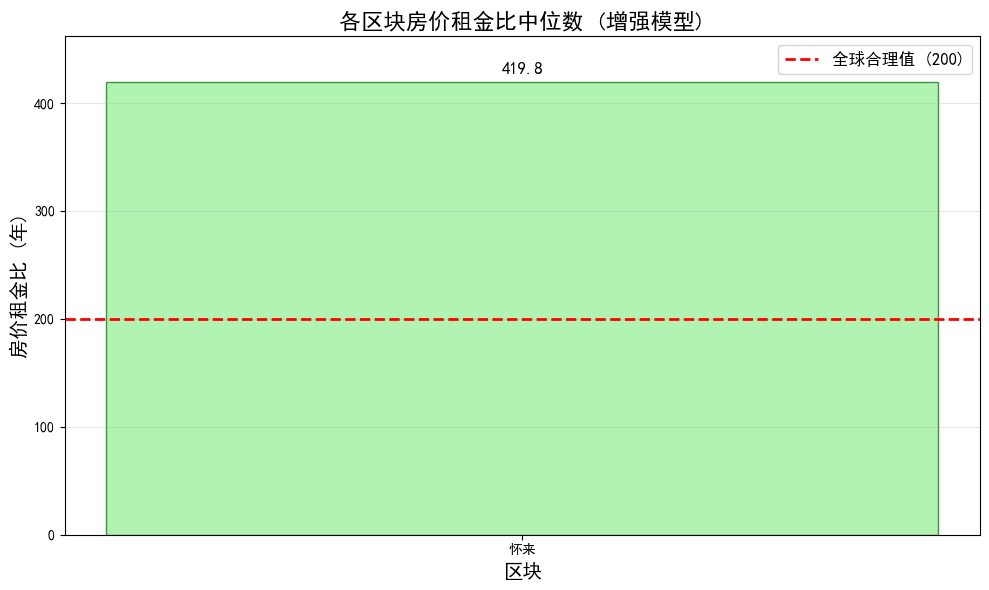

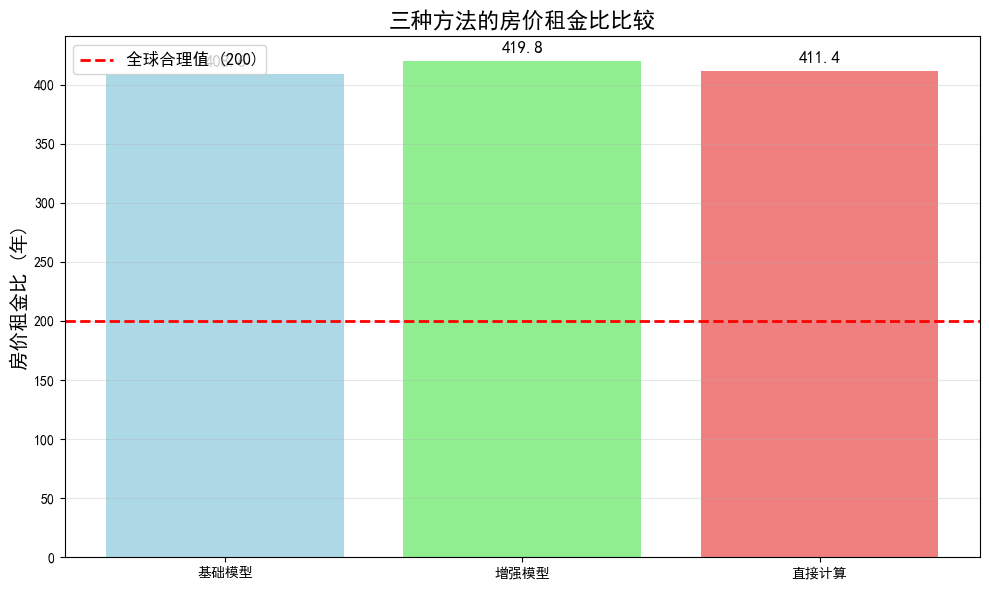


样本量分析:
房价数据样本量: 2895
租金数据样本量: 75
总数据样本量: 2970

分析完成!
增强模型图表已保存为 'median_price_to_rent_ratio_plus_by_block.png'
比较图表已保存为 'comparison_price_to_rent_ratios.png'
预测结果已保存为 'predicted_price_rent_ratios_plus.csv'


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取数据
housing_df = pd.read_csv('huailai_housing_price.csv')
rent_df = pd.read_csv('huailai_rent_price.csv')

# 2. 准备数据
# 对于房价数据
X_house = housing_df[['m2']].copy()
le = LabelEncoder()
X_house['location_encoded'] = le.fit_transform(housing_df['location'])
y_house = housing_df['price_per_m2']
# 对于租金数据
X_rent = rent_df[['m2']].copy()
X_rent['location_encoded'] = le.transform(rent_df['location'])
y_rent = rent_df['price_per_m2']

# 3. 创建非线性特征和交互项
# 使用多项式特征创建非线性项和交互项
poly = PolynomialFeatures(degree=2, include_bias=False)
# 为房价数据创建增强特征
X_house_poly = poly.fit_transform(X_house[['m2', 'location_encoded']])
feature_names = poly.get_feature_names_out(['m2', 'location_encoded'])
X_house_plus = pd.DataFrame(X_house_poly, columns=feature_names)
# 为租金数据创建增强特征
X_rent_poly = poly.fit_transform(X_rent[['m2', 'location_encoded']])
X_rent_plus = pd.DataFrame(X_rent_poly, columns=feature_names)

# 4. 训练模型
# 基础模型
model_house = LinearRegression()
model_house.fit(X_house, y_house)

model_rent = LinearRegression()
model_rent.fit(X_rent, y_rent)

# 增强模型
model_house_plus = LinearRegression()
model_house_plus.fit(X_house_plus, y_house)

model_rent_plus = LinearRegression()
model_rent_plus.fit(X_rent_plus, y_rent)

# 5. 比较模型性能
# 预测并计算R²
y_house_pred = model_house.predict(X_house)
y_house_plus_pred = model_house_plus.predict(X_house_plus)

y_rent_pred = model_rent.predict(X_rent)
y_rent_plus_pred = model_rent_plus.predict(X_rent_plus)

r2_house = r2_score(y_house, y_house_pred)
r2_house_plus = r2_score(y_house, y_house_plus_pred)

r2_rent = r2_score(y_rent, y_rent_pred)
r2_rent_plus = r2_score(y_rent, y_rent_plus_pred)

print("模型比较:")
print(f"房价基础模型 R²: {r2_house:.4f}")
print(f"房价增强模型 R²: {r2_house_plus:.4f}")
print(f"租金基础模型 R²: {r2_rent:.4f}")
print(f"租金增强模型 R²: {r2_rent_plus:.4f}")

# 6. 使用增强模型预测所有数据
# 合并所有数据
all_data = pd.concat([housing_df, rent_df], ignore_index=True)
X_all = all_data[['m2']].copy()
X_all['location_encoded'] = le.transform(all_data['location'])
# 为所有数据创建增强特征
X_all_poly = poly.fit_transform(X_all[['m2', 'location_encoded']])
X_all_plus = pd.DataFrame(X_all_poly, columns=feature_names)
# 使用增强模型预测
predicted_house_price_plus = model_house_plus.predict(X_all_plus)
predicted_rent_price_plus = model_rent_plus.predict(X_all_plus)
# 计算房价租金比
all_data['predicted_house_price_plus'] = predicted_house_price_plus
all_data['predicted_rent_price_plus'] = predicted_rent_price_plus
all_data['price_to_rent_ratio_plus'] = predicted_house_price_plus / (predicted_rent_price_plus)

# 7. 按区块计算中位数房价租金比
median_ratio_by_block_plus = all_data.groupby('location')['price_to_rent_ratio_plus'].median()
print(f"\n各区块房价租金比中位数 (增强模型):")
print(median_ratio_by_block_plus)

# 8. 绘制柱状图 (Figure C)
fig, ax = plt.subplots(figsize=(10, 6))
# 创建柱状图
bars = ax.bar(median_ratio_by_block_plus.index, median_ratio_by_block_plus.values, 
             color='lightgreen', alpha=0.7, edgecolor='darkgreen')
# 添加全球合理值参考线
ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=12)
# 设置图表标题和标签
ax.set_title('各区块房价租金比中位数 (增强模型)', fontsize=16, fontweight='bold')
ax.set_ylabel('房价租金比 (年)', fontsize=14)
ax.set_xlabel('区块', fontsize=14)
ax.legend(fontsize=12)
# 添加网格
ax.grid(axis='y', alpha=0.3)
# 设置y轴范围
max_ratio = median_ratio_by_block_plus.max()
ax.set_ylim(0, max(max_ratio * 1.1, 250))

plt.tight_layout()
plt.savefig('median_price_to_rent_ratio_plus_by_block.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. 比较三种方法的房价租金比
# 方法1: 基础模型
# 方法2: 增强模型
# 方法3: 直接计算 (使用观测值的中位数)
# 计算直接方法
direct_housing_median = housing_df['price_per_m2'].median()
direct_rent_median = rent_df['price_per_m2'].median()
direct_ratio = direct_housing_median / (direct_rent_median)
# 重新计算基础模型的比值
predicted_house_price_base = model_house.predict(X_all)
predicted_rent_price_base = model_rent.predict(X_all)
all_data['price_to_rent_ratio_base'] = predicted_house_price_base / (predicted_rent_price_base)
median_ratio_by_block_base = all_data.groupby('location')['price_to_rent_ratio_base'].median()
# 创建比较图表
methods = ['基础模型', '增强模型', '直接计算']
ratios = [median_ratio_by_block_base.iloc[0], median_ratio_by_block_plus.iloc[0], direct_ratio]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(methods, ratios, color=['lightblue', 'lightgreen', 'lightcoral'])
# 添加全球合理值参考线
ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar, ratio in zip(bars, ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{ratio:.1f}', ha='center', va='bottom', fontsize=12)
# 设置图表标题和标签
ax.set_title('三种方法的房价租金比比较', fontsize=16, fontweight='bold')
ax.set_ylabel('房价租金比 (年)', fontsize=14)
ax.legend(fontsize=12)
# 添加网格
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_price_to_rent_ratios.png', dpi=300, bbox_inches='tight')
plt.show()
# 10. 样本量分析
print(f"\n样本量分析:")
print(f"房价数据样本量: {len(housing_df)}")
print(f"租金数据样本量: {len(rent_df)}")
print(f"总数据样本量: {len(all_data)}")
# 11. 保存结果
all_data.to_csv('predicted_price_rent_ratios_plus.csv', index=False, encoding='utf-8-sig')
print("\n分析完成!")
print(f"增强模型图表已保存为 'median_price_to_rent_ratio_plus_by_block.png'")
print(f"比较图表已保存为 'comparison_price_to_rent_ratios.png'")
print(f"预测结果已保存为 'predicted_price_rent_ratios_plus.csv'")

## HW3-3: Data Research （多地区数据分析：数据来源于同学在群内发的csv）

=== 数据概览 ===
房价数据总行数: 3507
租金数据总行数: 325
房价数据地区分布:
region
怀来     2895
下花园     448
张北      164
Name: count, dtype: int64
租金数据地区分布:
region
下花园    175
怀来      75
张北      75
Name: count, dtype: int64

=== 各区域房价数据描述 ===

--- 怀来 ---
       price_per_m2           m2
count   2895.000000  2895.000000
mean    7541.680484   122.970542
std     4262.646917    77.332318
min     2000.000000    33.000000
25%     4553.000000    78.480000
50%     6262.000000   102.000000
75%     9457.500000   140.000000
max    36505.000000   800.000000
单价异常值数量: 109
面积异常值数量: 224

--- 张北 ---
       price_per_m2          m2
count    164.000000  164.000000
mean    4124.431704   94.586341
std     1028.799555   45.310540
min     1889.882827   47.910000
25%     3401.045956   84.007500
50%     4089.692742   90.390000
75%     4858.299595   99.355000
max     6861.063465  642.480000
单价异常值数量: 0
面积异常值数量: 13

--- 下花园 ---
       price_per_m2          m2
count    448.000000  448.000000
mean    3650.256696   90.449911
std     1488.341923

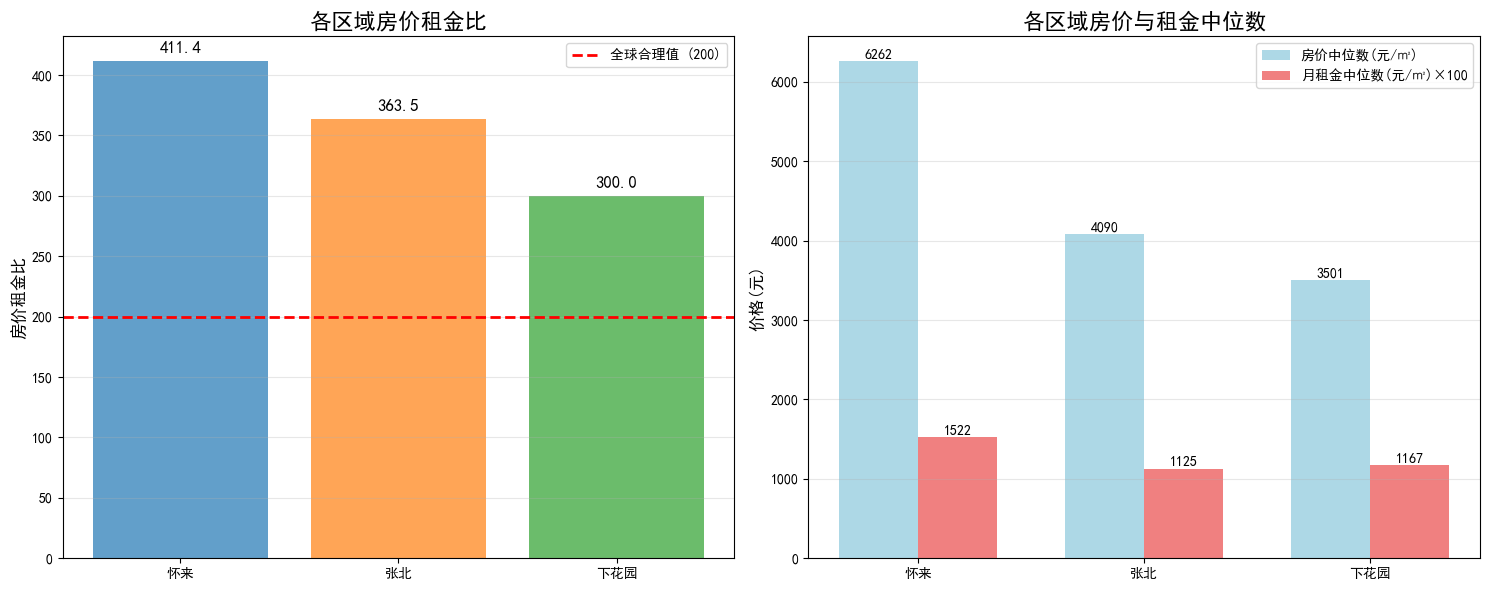


=== 分析完成 ===
各区域房价租金比已保存为 'price_to_rent_ratios_by_region.csv'
合并数据已保存为 'all_regions_combined_data.csv'
图表已保存为 'multi_region_price_to_rent_ratio.png'

=== 分析报告 ===

怀来地区:
  - 房价中位数: 6262.00 元/㎡
  - 月租金中位数: 15.22 元/㎡
  - 房价租金比: 411.43
  - 分析: 房价租金比(411.43)高于全球合理值(200)，可能存在房价泡沫

张北地区:
  - 房价中位数: 4089.69 元/㎡
  - 月租金中位数: 11.25 元/㎡
  - 房价租金比: 363.53
  - 分析: 房价租金比(363.53)高于全球合理值(200)，可能存在房价泡沫

下花园地区:
  - 房价中位数: 3501.00 元/㎡
  - 月租金中位数: 11.67 元/㎡
  - 房价租金比: 300.00
  - 分析: 房价租金比(300.00)高于全球合理值(200)，可能存在房价泡沫


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取所有地区的数据
# 房价数据
huailai_housing = pd.read_csv('huailai_housing_price.csv')
zhangbei_housing = pd.read_csv('zhangbei_housing_price.csv')
xiahuayuan_housing = pd.read_csv('xiahuayuan_housing_price.csv')
# 租金数据
huailai_rent = pd.read_csv('huailai_rent_price.csv')
zhangbei_rent = pd.read_csv('zhangbei_rent_price.csv')
xiahuayuan_rent = pd.read_csv('xiahuayuan_rent_price.csv')

# 2. 为每个数据集添加地区标识
huailai_housing['region'] = '怀来'
zhangbei_housing['region'] = '张北'
xiahuayuan_housing['region'] = '下花园'
huailai_rent['region'] = '怀来'
zhangbei_rent['region'] = '张北'
xiahuayuan_rent['region'] = '下花园'

# 3. 合并所有数据
all_housing = pd.concat([huailai_housing, zhangbei_housing, xiahuayuan_housing], ignore_index=True)
all_rent = pd.concat([huailai_rent, zhangbei_rent, xiahuayuan_rent], ignore_index=True)
print("=== 数据概览 ===")
print(f"房价数据总行数: {len(all_housing)}")
print(f"租金数据总行数: {len(all_rent)}")
print(f"房价数据地区分布:\n{all_housing['region'].value_counts()}")
print(f"租金数据地区分布:\n{all_rent['region'].value_counts()}")

# 4. 数据描述和异常值检测
def detect_outliers_iqr(df, column):
    """使用IQR方法检测异常值"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers
print("\n=== 各区域房价数据描述 ===")
for region in all_housing['region'].unique():
    region_data = all_housing[all_housing['region'] == region]
    print(f"\n--- {region} ---")
    print(region_data[['price_per_m2', 'm2']].describe())
    # 检测异常值
    price_outliers = detect_outliers_iqr(region_data, 'price_per_m2')
    area_outliers = detect_outliers_iqr(region_data, 'm2')
    print(f"单价异常值数量: {len(price_outliers)}")
    print(f"面积异常值数量: {len(area_outliers)}")

print("\n=== 各区域租金数据描述 ===")
for region in all_rent['region'].unique():
    region_data = all_rent[all_rent['region'] == region]
    print(f"\n--- {region} ---")
    print(region_data[['price_per_m2', 'm2']].describe())
    # 检测异常值
    price_outliers = detect_outliers_iqr(region_data, 'price_per_m2')
    area_outliers = detect_outliers_iqr(region_data, 'm2')
    print(f"单价异常值数量: {len(price_outliers)}")
    print(f"面积异常值数量: {len(area_outliers)}")

# 5. 计算各区域的房价租金比
# 房价租金比 = 房价(元/㎡) / (月租金(元/㎡/月))
price_to_rent_ratios = []

for region in all_housing['region'].unique():
    # 获取该区域的房价和租金数据
    region_housing = all_housing[all_housing['region'] == region]
    region_rent = all_rent[all_rent['region'] == region]
    # 计算中位数
    median_housing_price = region_housing['price_per_m2'].median()
    median_rent_price = region_rent['price_per_m2'].median()
    # 避免除零错误
    if median_rent_price > 0:
        price_to_rent_ratio = median_housing_price / (median_rent_price)
    else:
        price_to_rent_ratio = 0
    
    price_to_rent_ratios.append({
        'region': region,
        'housing_price_median': median_housing_price,
        'rent_price_median': median_rent_price,
        'price_to_rent_ratio': price_to_rent_ratio
    })

# 转换为DataFrame
ratio_df = pd.DataFrame(price_to_rent_ratios)
print("\n=== 各区域房价租金比 ===")
print(ratio_df)

# 6. 绘制房价租金比柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# 子图1: 房价租金比
regions = ratio_df['region']
ratios = ratio_df['price_to_rent_ratio']
bars = ax1.bar(regions, ratios, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
ax1.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=12)

ax1.set_title('各区域房价租金比', fontsize=16, fontweight='bold')
ax1.set_ylabel('房价租金比', fontsize=12)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# 子图2: 房价和租金中位数对比
x = np.arange(len(regions))
width = 0.35
bars1 = ax2.bar(x - width/2, ratio_df['housing_price_median'], width, 
                label='房价中位数(元/㎡)', color='lightblue')
bars2 = ax2.bar(x + width/2, ratio_df['rent_price_median'] * 100, width, 
                label='月租金中位数(元/㎡)×100', color='lightcoral')
ax2.set_title('各区域房价与租金中位数', fontsize=16, fontweight='bold')
ax2.set_ylabel('价格(元)', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(regions)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# 在柱子上添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('multi_region_price_to_rent_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. 保存分析结果
# 为所有数据添加类型标识
all_housing['type'] = 'sale'
all_rent['type'] = 'rent'
# 合并所有数据
all_combined = pd.concat([all_housing, all_rent], ignore_index=True)
# 保存合并后的数据
all_combined.to_csv('all_regions_combined_data.csv', index=False, encoding='utf-8-sig')
ratio_df.to_csv('price_to_rent_ratios_by_region.csv', index=False, encoding='utf-8-sig')
print("\n=== 分析完成 ===")
print(f"各区域房价租金比已保存为 'price_to_rent_ratios_by_region.csv'")
print(f"合并数据已保存为 'all_regions_combined_data.csv'")
print(f"图表已保存为 'multi_region_price_to_rent_ratio.png'")

# 8. 生成分析报告
print("\n=== 分析报告 ===")
for _, row in ratio_df.iterrows():
    region = row['region']
    ratio = row['price_to_rent_ratio']
    housing_price = row['housing_price_median']
    rent_price = row['rent_price_median']
    print(f"\n{region}地区:")
    print(f"  - 房价中位数: {housing_price:.2f} 元/㎡")
    print(f"  - 月租金中位数: {rent_price:.2f} 元/㎡")
    print(f"  - 房价租金比: {ratio:.2f}")
    
    if ratio > 200:
        print(f"  - 分析: 房价租金比({ratio:.2f})高于全球合理值(200)，可能存在房价泡沫")
    elif ratio < 150:
        print(f"  - 分析: 房价租金比({ratio:.2f})低于合理范围，投资价值可能较高")
    else:
        print(f"  - 分析: 房价租金比({ratio:.2f})处于合理范围内")


## HW3-4: Data Modeling （多地区建模分析）

数据概览:
数据形状: (3832, 6)
地区分布:
region
怀来     2970
下花园     623
张北      239
Name: count, dtype: int64
类型分布:
type
sale    3507
rent     325
Name: count, dtype: int64

房价数据: 3507 条记录
租金数据: 325 条记录

房价模型特征: (3507, 2)
租金模型特征: (325, 2)

模型训练完成:
房价模型 R²: 0.3068
租金模型 R²: 0.0487

各区块房价租金比中位数:
  下花园: 270.08
  张北: 353.91
  怀来: 432.87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13980\2312484690.py:111: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13980\2312484690.py:112: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.savefig('model_based_price_to_rent_analysis.png', dpi=300, bbox_inches='tight')
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


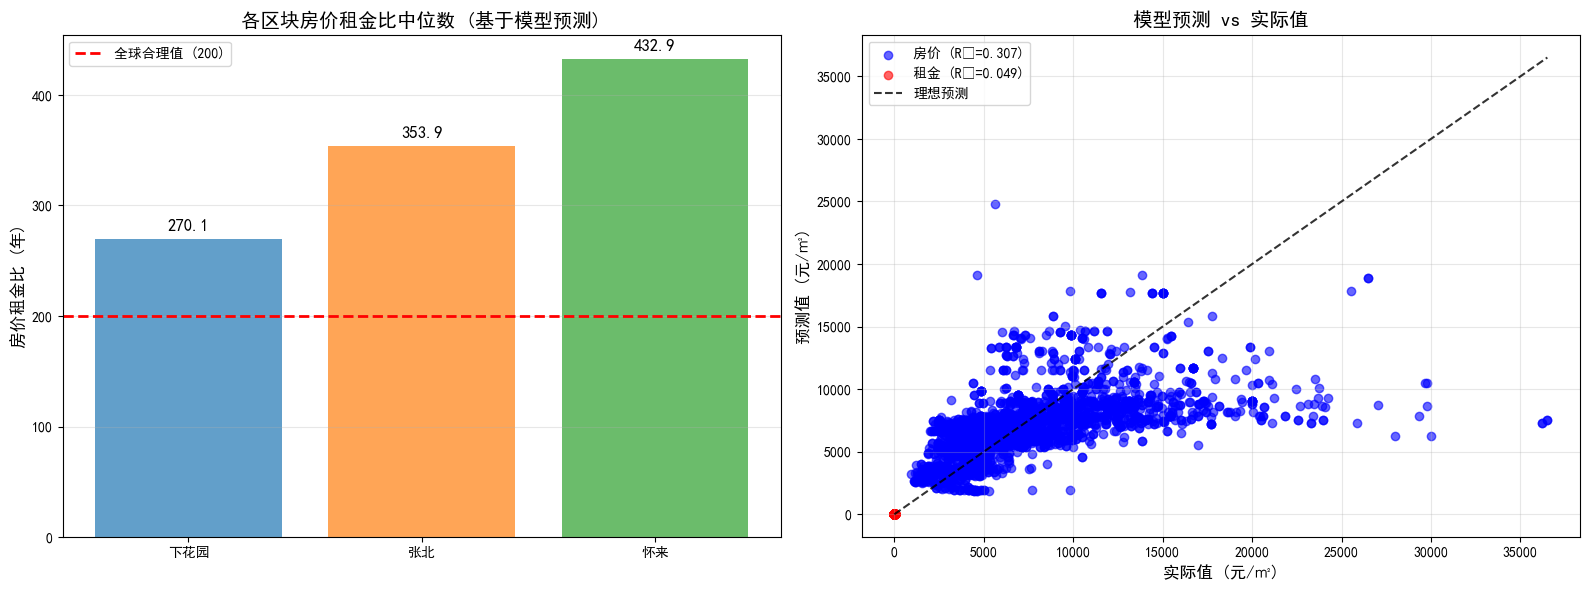


=== 模型详细信息 ===
房价模型:
  系数 (m2, location): [  25.53183427 1611.85138517]
  截距: 1148.55
  R²: 0.3068

租金模型:
  系数 (m2, location): [-0.0143402   1.96624207]
  截距: 13.62
  R²: 0.0487

=== 各地区预测分析 ===
怀来 - 房价预测平均绝对误差: 2648.64 元/㎡
怀来 - 租金预测平均绝对误差: 5.74 元/㎡
张北 - 房价预测平均绝对误差: 1268.64 元/㎡
张北 - 租金预测平均绝对误差: 4.05 元/㎡
下花园 - 房价预测平均绝对误差: 1152.61 元/㎡
下花园 - 租金预测平均绝对误差: 4.16 元/㎡

=== 分析完成 ===
图表已保存为 'model_based_price_to_rent_analysis.png'
预测结果已保存为 'model_predictions_all_regions.csv'
模型系数已保存为 'model_coefficients.csv'

=== 分析报告 ===
基于线性回归模型的房价租金比分析:
使用的模型: price/m2 = β0 + β1×m2 + β2×location + ε
            rent/m2 = β0 + β1×m2 + β2×location + ε

下花园地区:
  - 预测的房价租金比中位数: 270.08
  - 投资分析: 房价租金比偏高，房产投资回收期较长

张北地区:
  - 预测的房价租金比中位数: 353.91
  - 投资分析: 房价租金比偏高，房产投资回收期较长

怀来地区:
  - 预测的房价租金比中位数: 432.87
  - 投资分析: 房价租金比偏高，房产投资回收期较长

模型效果总结:
  - 房价模型解释方差: 30.7%
  - 租金模型解释方差: 4.9%
  - 建议: 模型拟合效果一般，可考虑特征工程或其他模型


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取合并后的数据
all_combined = pd.read_csv('all_regions_combined_data.csv')
print("数据概览:")
print(f"数据形状: {all_combined.shape}")
print(f"地区分布:\n{all_combined['region'].value_counts()}")
print(f"类型分布:\n{all_combined['type'].value_counts()}")

# 2. 分离房价数据和租金数据
housing_df = all_combined[all_combined['type'] == 'sale'].copy()
rent_df = all_combined[all_combined['type'] == 'rent'].copy()
print(f"\n房价数据: {len(housing_df)} 条记录")
print(f"租金数据: {len(rent_df)} 条记录")

# 3. 准备数据用于建模
# 对地区进行编码
le = LabelEncoder()
all_regions = pd.concat([housing_df['region'], rent_df['region']])
le.fit(all_regions)
# 对于房价数据
X_house = housing_df[['m2']].copy()
X_house['location_encoded'] = le.transform(housing_df['region'])
y_house = housing_df['price_per_m2']
# 对于租金数据
X_rent = rent_df[['m2']].copy()
X_rent['location_encoded'] = le.transform(rent_df['region'])
y_rent = rent_df['price_per_m2']
print(f"\n房价模型特征: {X_house.shape}")
print(f"租金模型特征: {X_rent.shape}")

# 4. 训练模型
# 模型1: 房价模型
model_house = LinearRegression()
model_house.fit(X_house, y_house)
house_r2 = model_house.score(X_house, y_house)
# 模型2: 租金模型
model_rent = LinearRegression()
model_rent.fit(X_rent, y_rent)
rent_r2 = model_rent.score(X_rent, y_rent)
print(f"\n模型训练完成:")
print(f"房价模型 R²: {house_r2:.4f}")
print(f"租金模型 R²: {rent_r2:.4f}")

# 5. 预测所有数据的房价和租金
# 使用所有数据（包括房价和租金数据）
X_all = all_combined[['m2']].copy()
X_all['location_encoded'] = le.transform(all_combined['region'])
# 预测房价和租金
all_combined['predicted_house_price_per_m2'] = model_house.predict(X_all)
all_combined['predicted_rent_price_per_m2'] = model_rent.predict(X_all)

# 6. 计算每个数据点的房价租金比
# 房价租金比 = 房价(元/㎡) / (月租金(元/㎡/月))
all_combined['price_to_rent_ratio'] = (
    all_combined['predicted_house_price_per_m2'] / 
    (all_combined['predicted_rent_price_per_m2'])
)
# 处理可能的无穷大值（由于除零）
all_combined['price_to_rent_ratio'] = all_combined['price_to_rent_ratio'].replace([np.inf, -np.inf], np.nan)

# 7. 按区块计算中位数房价租金比
median_ratio_by_region = all_combined.groupby('region')['price_to_rent_ratio'].median()
print(f"\n各区块房价租金比中位数:")
for region, ratio in median_ratio_by_region.items():
    print(f"  {region}: {ratio:.2f}")

# 8. 绘制柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# 子图1: 各区块房价租金比中位数
regions = median_ratio_by_region.index
ratios = median_ratio_by_region.values
bars = ax1.bar(regions, ratios, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
ax1.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=12)
ax1.set_title('各区块房价租金比中位数 (基于模型预测)', fontsize=14, fontweight='bold')
ax1.set_ylabel('房价租金比 (年)', fontsize=12)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# 子图2: 模型预测 vs 实际值对比
# 房价预测对比
housing_actual = all_combined[all_combined['type'] == 'sale']['price_per_m2']
housing_pred = all_combined[all_combined['type'] == 'sale']['predicted_house_price_per_m2']
# 租金预测对比
rent_actual = all_combined[all_combined['type'] == 'rent']['price_per_m2']
rent_pred = all_combined[all_combined['type'] == 'rent']['predicted_rent_price_per_m2']
# 创建散点图
ax2.scatter(housing_actual, housing_pred, alpha=0.6, color='blue', label=f'房价 (R²={house_r2:.3f})')
ax2.scatter(rent_actual, rent_pred, alpha=0.6, color='red', label=f'租金 (R²={rent_r2:.3f})')
# 添加理想预测线
min_val = min(housing_actual.min(), rent_actual.min())
max_val = max(housing_actual.max(), rent_actual.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='理想预测')
ax2.set_xlabel('实际值 (元/㎡)', fontsize=12)
ax2.set_ylabel('预测值 (元/㎡)', fontsize=12)
ax2.set_title('模型预测 vs 实际值', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('model_based_price_to_rent_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. 输出详细模型信息
print("\n=== 模型详细信息 ===")
print("房价模型:")
print(f"  系数 (m2, location): {model_house.coef_}")
print(f"  截距: {model_house.intercept_:.2f}")
print(f"  R²: {house_r2:.4f}")
print("\n租金模型:")
print(f"  系数 (m2, location): {model_rent.coef_}")
print(f"  截距: {model_rent.intercept_:.2f}")
print(f"  R²: {rent_r2:.4f}")

# 10. 按地区分析预测效果
print("\n=== 各地区预测分析 ===")
for region in all_combined['region'].unique():
    region_data = all_combined[all_combined['region'] == region]
    housing_data = region_data[region_data['type'] == 'sale']
    rent_data = region_data[region_data['type'] == 'rent']
    if len(housing_data) > 0:
        house_mae = np.mean(np.abs(housing_data['price_per_m2'] - housing_data['predicted_house_price_per_m2']))
        print(f"{region} - 房价预测平均绝对误差: {house_mae:.2f} 元/㎡")
    if len(rent_data) > 0:
        rent_mae = np.mean(np.abs(rent_data['price_per_m2'] - rent_data['predicted_rent_price_per_m2']))
        print(f"{region} - 租金预测平均绝对误差: {rent_mae:.2f} 元/㎡")

# 11. 保存预测结果
output_columns = ['region', 'type', 'm2', 'price_per_m2', 
                 'predicted_house_price_per_m2', 'predicted_rent_price_per_m2', 
                 'price_to_rent_ratio']
all_combined[output_columns].to_csv('model_predictions_all_regions.csv', index=False, encoding='utf-8-sig')
# 保存模型系数 - 修复了拼写错误
model_coefficients = pd.DataFrame({
    'model': ['房价模型', '租金模型'],
    'm2_coefficient': [model_house.coef_[0], model_rent.coef_[0]],
    'location_coefficient': [model_house.coef_[1], model_rent.coef_[1]],  # 修复了这里的拼写错误
    'intercept': [model_house.intercept_, model_rent.intercept_],
    'r_squared': [house_r2, rent_r2]
})
model_coefficients.to_csv('model_coefficients.csv', index=False, encoding='utf-8-sig')
print("\n=== 分析完成 ===")
print(f"图表已保存为 'model_based_price_to_rent_analysis.png'")
print(f"预测结果已保存为 'model_predictions_all_regions.csv'")
print(f"模型系数已保存为 'model_coefficients.csv'")

# 12. 生成分析报告
print("\n=== 分析报告 ===")
print("基于线性回归模型的房价租金比分析:")
print(f"使用的模型: price/m2 = β0 + β1×m2 + β2×location + ε")
print(f"            rent/m2 = β0 + β1×m2 + β2×location + ε")
for region in median_ratio_by_region.index:
    ratio = median_ratio_by_region[region]
    print(f"\n{region}地区:")
    print(f"  - 预测的房价租金比中位数: {ratio:.2f}")
    
    if ratio > 250:
        print(f"  - 投资分析: 房价租金比偏高，房产投资回收期较长")
    elif ratio < 150:
        print(f"  - 投资分析: 房价租金比较低，可能具有较好的投资价值")
    else:
        print(f"  - 投资分析: 房价租金比处于中等水平")

print(f"\n模型效果总结:")
print(f"  - 房价模型解释方差: {house_r2:.1%}")
print(f"  - 租金模型解释方差: {rent_r2:.1%}")
print(f"  - 建议: {'模型拟合效果较好' if house_r2 > 0.5 and rent_r2 > 0.5 else '模型拟合效果一般，可考虑特征工程或其他模型'}")

## HW3-5: Data Science Modeling Pro Max （多地区增强建模分析）

数据概览:
数据形状: (3832, 6)
地区分布:
region
怀来     2970
下花园     623
张北      239
Name: count, dtype: int64
类型分布:
type
sale    3507
rent     325
Name: count, dtype: int64

房价数据: 3507 条记录
租金数据: 325 条记录

房价模型特征: (3507, 2)
租金模型特征: (325, 2)

增强特征维度:
房价增强特征: (3507, 5)
租金增强特征: (325, 5)
特征名称: ['m2' 'location_encoded' 'm2^2' 'm2 location_encoded' 'location_encoded^2']

=== 模型性能比较 ===
房价基础模型 (Model 1) R²: 0.3068
房价增强模型 (Model 1+) R²: 0.3619
R²提升: +0.0551

租金基础模型 (Model 2) R²: 0.0487
租金增强模型 (Model 2+) R²: 0.3533
R²提升: +0.3046

=== 各区块房价租金比中位数 (增强模型) ===
  下花园: 349.23
  张北: 339.80
  怀来: 424.01


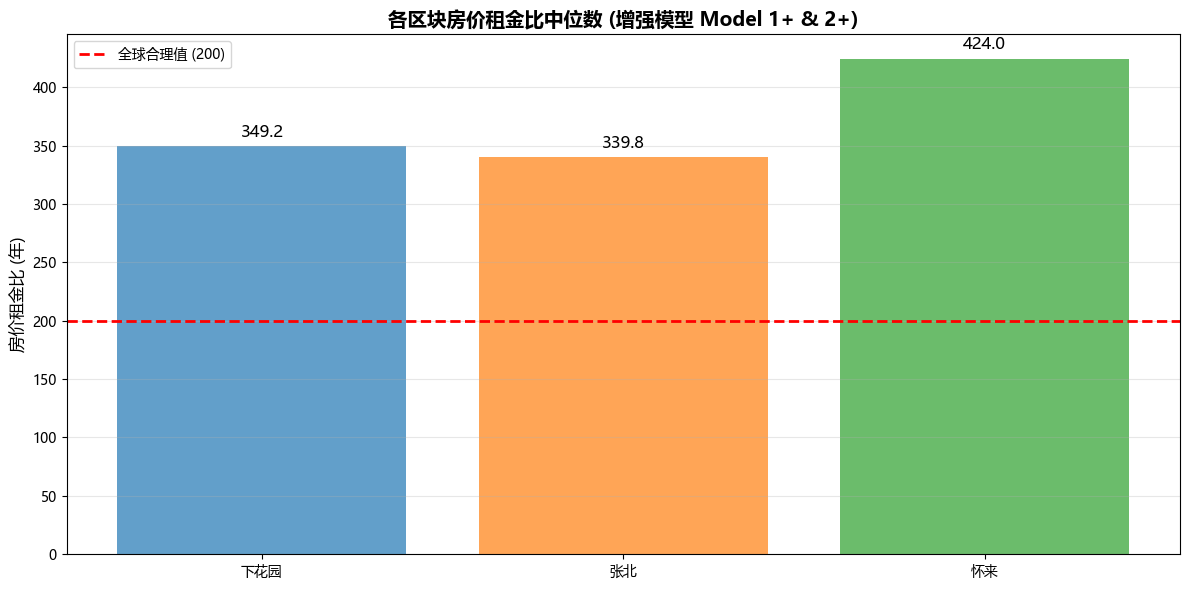


=== 三种方法比较 ===

三种方法的房价租金比比较:
  region        基础模型        增强模型        直接计算
0     怀来  432.867060  424.014279  411.432326
1     张北  353.910507  339.799847  363.528244
2    下花园  270.076158  349.230676  300.000000


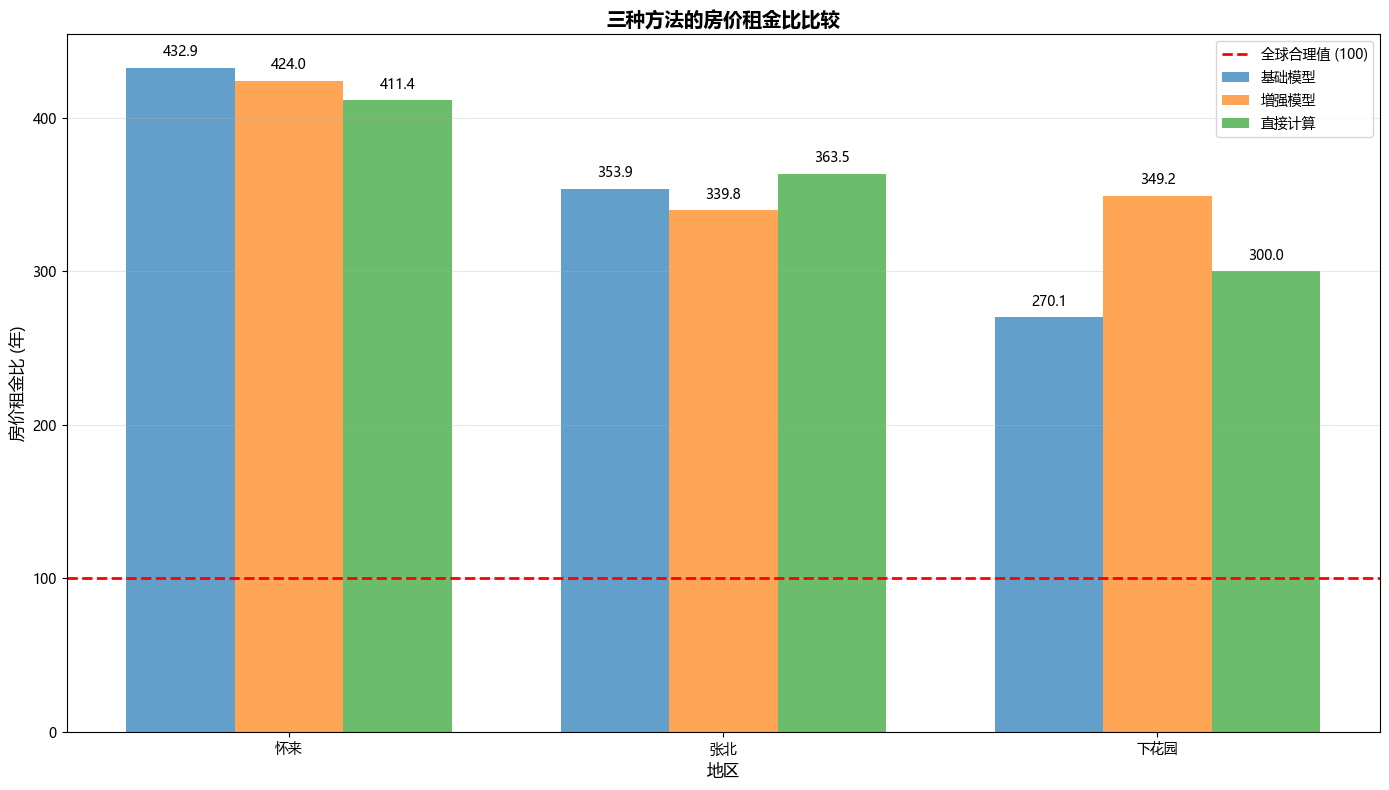


=== 样本量分析和可信度评估 ===

怀来地区:
  房价样本量: 2895
  租金样本量: 75
  总样本量: 2970

张北地区:
  房价样本量: 164
  租金样本量: 75
  总样本量: 239

下花园地区:
  房价样本量: 448
  租金样本量: 175
  总样本量: 623

基于样本量的可信度分析:

怀来地区:
  样本量充足，所有方法都相对可靠
  推荐方法: 增强模型（能捕捉更复杂的关系）

张北地区:
  样本量充足，所有方法都相对可靠
  推荐方法: 增强模型（能捕捉更复杂的关系）

下花园地区:
  样本量充足，所有方法都相对可靠
  推荐方法: 增强模型（能捕捉更复杂的关系）

=== 分析完成 ===
增强模型图表已保存为 'median_price_to_rent_ratio_plus_by_region.png'
比较图表已保存为 'comparison_price_to_rent_ratios_methods.png'
预测结果已保存为 'model_predictions_comparison_all_regions.csv'
模型性能比较已保存为 'model_performance_comparison.csv'

=== 详细分析报告 ===
1. 模型性能分析:
   - 增强模型在房价预测上的R²从 0.3068 提升到 0.3619
   - 增强模型在租金预测上的R²从 0.0487 提升到 0.3533
   - 增强模型有更高的R²，因为它能捕捉面积和位置之间的非线性关系和交互效应

2. 房价租金比比较:

   怀来地区:
     基础模型: 432.87
     增强模型: 424.01
     直接计算: 411.43

   张北地区:
     基础模型: 353.91
     增强模型: 339.80
     直接计算: 363.53

   下花园地区:
     基础模型: 270.08
     增强模型: 349.23
     直接计算: 300.00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取合并后的多地区数据
all_combined = pd.read_csv('all_regions_combined_data.csv')
print("数据概览:")
print(f"数据形状: {all_combined.shape}")
print(f"地区分布:\n{all_combined['region'].value_counts()}")
print(f"类型分布:\n{all_combined['type'].value_counts()}")

# 2. 分离房价数据和租金数据
housing_df = all_combined[all_combined['type'] == 'sale'].copy()
rent_df = all_combined[all_combined['type'] == 'rent'].copy()
print(f"\n房价数据: {len(housing_df)} 条记录")
print(f"租金数据: {len(rent_df)} 条记录")

# 3. 准备数据
# 对地区进行编码
le = LabelEncoder()
all_regions = pd.concat([housing_df['region'], rent_df['region']])
le.fit(all_regions)
# 对于房价数据
X_house = housing_df[['m2']].copy()
X_house['location_encoded'] = le.transform(housing_df['region'])
y_house = housing_df['price_per_m2']
# 对于租金数据
X_rent = rent_df[['m2']].copy()
X_rent['location_encoded'] = le.transform(rent_df['region'])
y_rent = rent_df['price_per_m2']
print(f"\n房价模型特征: {X_house.shape}")
print(f"租金模型特征: {X_rent.shape}")

# 4. 创建非线性特征和交互项
# 使用多项式特征创建非线性项和交互项 
poly = PolynomialFeatures(degree=2, include_bias=False)
# 为房价数据创建增强特征
X_house_poly = poly.fit_transform(X_house[['m2', 'location_encoded']])
feature_names = poly.get_feature_names_out(['m2', 'location_encoded'])
X_house_plus = pd.DataFrame(X_house_poly, columns=feature_names)
# 为租金数据创建增强特征
X_rent_poly = poly.fit_transform(X_rent[['m2', 'location_encoded']])
X_rent_plus = pd.DataFrame(X_rent_poly, columns=feature_names)
print(f"\n增强特征维度:")
print(f"房价增强特征: {X_house_plus.shape}")
print(f"租金增强特征: {X_rent_plus.shape}")
print(f"特征名称: {feature_names}")

# 5. 训练模型
# 基础模型 (Model 1, Model 2)
model_house = LinearRegression()
model_house.fit(X_house, y_house)
model_rent = LinearRegression()
model_rent.fit(X_rent, y_rent)
# 增强模型 (Model 1+, Model 2+)
model_house_plus = LinearRegression()
model_house_plus.fit(X_house_plus, y_house)
model_rent_plus = LinearRegression()
model_rent_plus.fit(X_rent_plus, y_rent)

# 6. 比较模型性能
# 预测并计算R²
y_house_pred = model_house.predict(X_house)
y_house_plus_pred = model_house_plus.predict(X_house_plus)
y_rent_pred = model_rent.predict(X_rent)
y_rent_plus_pred = model_rent_plus.predict(X_rent_plus)

r2_house = r2_score(y_house, y_house_pred)
r2_house_plus = r2_score(y_house, y_house_plus_pred)
r2_rent = r2_score(y_rent, y_rent_pred)
r2_rent_plus = r2_score(y_rent, y_rent_plus_pred)

print("\n=== 模型性能比较 ===")
print(f"房价基础模型 (Model 1) R²: {r2_house:.4f}")
print(f"房价增强模型 (Model 1+) R²: {r2_house_plus:.4f}")
print(f"R²提升: {r2_house_plus - r2_house:+.4f}")

print(f"\n租金基础模型 (Model 2) R²: {r2_rent:.4f}")
print(f"租金增强模型 (Model 2+) R²: {r2_rent_plus:.4f}")
print(f"R²提升: {r2_rent_plus - r2_rent:+.4f}")

# 7. 使用增强模型预测所有数据
# 为所有数据创建增强特征
X_all = all_combined[['m2']].copy()
X_all['location_encoded'] = le.transform(all_combined['region'])
X_all_poly = poly.transform(X_all[['m2', 'location_encoded']])
X_all_plus = pd.DataFrame(X_all_poly, columns=feature_names)
# 使用增强模型预测
all_combined['predicted_house_price_plus'] = model_house_plus.predict(X_all_plus)
all_combined['predicted_rent_price_plus'] = model_rent_plus.predict(X_all_plus)
# 计算房价租金比
all_combined['price_to_rent_ratio_plus'] = (
    all_combined['predicted_house_price_plus'] / 
    (all_combined['predicted_rent_price_plus'])
)
# 处理可能的无穷大值
all_combined['price_to_rent_ratio_plus'] = all_combined['price_to_rent_ratio_plus'].replace([np.inf, -np.inf], np.nan)

# 8. 按区块计算中位数房价租金比 (Figure C)
median_ratio_by_region_plus = all_combined.groupby('region')['price_to_rent_ratio_plus'].median()
print(f"\n=== 各区块房价租金比中位数 (增强模型) ===")
for region, ratio in median_ratio_by_region_plus.items():
    print(f"  {region}: {ratio:.2f}")

# 9. 绘制柱状图 (Figure C)
fig, ax = plt.subplots(figsize=(12, 6))
regions = median_ratio_by_region_plus.index
ratios = median_ratio_by_region_plus.values
bars = ax.bar(regions, ratios, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球合理值 (200)')
# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=12)
ax.set_title('各区块房价租金比中位数 (增强模型 Model 1+ & 2+)', fontsize=14, fontweight='bold')
ax.set_ylabel('房价租金比 (年)', fontsize=12)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('median_price_to_rent_ratio_plus_by_region.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. 比较三种方法的房价租金比
print("\n=== 三种方法比较 ===")

# 方法1: 基础模型 
X_all_base = all_combined[['m2']].copy()
X_all_base['location_encoded'] = le.transform(all_combined['region'])
all_combined['predicted_house_price_base'] = model_house.predict(X_all_base)
all_combined['predicted_rent_price_base'] = model_rent.predict(X_all_base)
all_combined['price_to_rent_ratio_base'] = (
    all_combined['predicted_house_price_base'] / 
    (all_combined['predicted_rent_price_base'] )
)
all_combined['price_to_rent_ratio_base'] = all_combined['price_to_rent_ratio_base'].replace([np.inf, -np.inf], np.nan)
median_ratio_by_region_base = all_combined.groupby('region')['price_to_rent_ratio_base'].median()

# 方法2: 增强模型 (已计算)
# 方法3: 直接计算 (使用观测值的中位数)
direct_ratios = {}
for region in all_combined['region'].unique():
    region_housing = housing_df[housing_df['region'] == region]['price_per_m2'].median()
    region_rent = rent_df[rent_df['region'] == region]['price_per_m2'].median()
    if region_rent > 0:
        direct_ratio = region_housing / (region_rent )
    else:
        direct_ratio = np.nan
    direct_ratios[region] = direct_ratio

# 创建比较数据
comparison_data = []
for region in all_combined['region'].unique():
    comparison_data.append({
        'region': region,
        '基础模型': median_ratio_by_region_base[region],
        '增强模型': median_ratio_by_region_plus[region],
        '直接计算': direct_ratios[region]
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n三种方法的房价租金比比较:")
print(comparison_df)

# 绘制比较图表
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(comparison_df['region']))
width = 0.25
bars1 = ax.bar(x - width, comparison_df['基础模型'], width, label='基础模型', alpha=0.7)
bars2 = ax.bar(x, comparison_df['增强模型'], width, label='增强模型', alpha=0.7)
bars3 = ax.bar(x + width, comparison_df['直接计算'], width, label='直接计算', alpha=0.7)
ax.axhline(y=100, color='red', linestyle='--', linewidth=2, label='全球合理值 (100)')

# 添加数值标签
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('地区', fontsize=12)
ax.set_ylabel('房价租金比 (年)', fontsize=12)
ax.set_title('三种方法的房价租金比比较', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['region'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_price_to_rent_ratios_methods.png', dpi=300, bbox_inches='tight')
plt.show()

# 11. 样本量分析和可信度评估
print("\n=== 样本量分析和可信度评估 ===")

# 各地区样本量统计
region_sample_sizes = {}
for region in all_combined['region'].unique():
    housing_count = len(housing_df[housing_df['region'] == region])
    rent_count = len(rent_df[rent_df['region'] == region])
    region_sample_sizes[region] = {
        'housing': housing_count,
        'rent': rent_count,
        'total': housing_count + rent_count
    }
    print(f"\n{region}地区:")
    print(f"  房价样本量: {housing_count}")
    print(f"  租金样本量: {rent_count}")
    print(f"  总样本量: {housing_count + rent_count}")

# 可信度分析
print(f"\n基于样本量的可信度分析:")
for region in all_combined['region'].unique():
    housing_count = region_sample_sizes[region]['housing']
    rent_count = region_sample_sizes[region]['rent']
    print(f"\n{region}地区:")
    if housing_count > 50 and rent_count > 50:
        print("  样本量充足，所有方法都相对可靠")
        recommended_method = "增强模型（能捕捉更复杂的关系）"
    elif housing_count > 30 or rent_count > 30:
        print("  样本量中等，基础模型可能更稳定")
        recommended_method = "基础模型（避免过拟合）"
    else:
        print("  样本量较小，直接计算可能更可靠")
        recommended_method = "直接计算（减少模型复杂度）"
    
    print(f"  推荐方法: {recommended_method}")

# 12. 保存结果
output_columns = ['region', 'type', 'm2', 'price_per_m2', 
                 'predicted_house_price_base', 'predicted_rent_price_base', 'price_to_rent_ratio_base',
                 'predicted_house_price_plus', 'predicted_rent_price_plus', 'price_to_rent_ratio_plus']

all_combined[output_columns].to_csv('model_predictions_comparison_all_regions.csv', index=False, encoding='utf-8-sig')
comparison_df.to_csv('price_to_rent_ratios_comparison.csv', index=False, encoding='utf-8-sig')
# 保存模型性能比较
performance_comparison = pd.DataFrame({
    'model_type': ['房价基础模型', '房价增强模型', '租金基础模型', '租金增强模型'],
    'r_squared': [r2_house, r2_house_plus, r2_rent, r2_rent_plus],
    'features': [str(X_house.columns.tolist()), str(X_house_plus.columns.tolist()), 
                str(X_rent.columns.tolist()), str(X_rent_plus.columns.tolist())]
})
performance_comparison.to_csv('model_performance_comparison.csv', index=False, encoding='utf-8-sig')

print("\n=== 分析完成 ===")
print(f"增强模型图表已保存为 'median_price_to_rent_ratio_plus_by_region.png'")
print(f"比较图表已保存为 'comparison_price_to_rent_ratios_methods.png'")
print(f"预测结果已保存为 'model_predictions_comparison_all_regions.csv'")
print(f"模型性能比较已保存为 'model_performance_comparison.csv'")

# 13. 详细分析报告
print("\n=== 详细分析报告 ===")
print("1. 模型性能分析:")
print(f"   - 增强模型在房价预测上的R²从 {r2_house:.4f} 提升到 {r2_house_plus:.4f}")
print(f"   - 增强模型在租金预测上的R²从 {r2_rent:.4f} 提升到 {r2_rent_plus:.4f}")
print("   - 增强模型有更高的R²，因为它能捕捉面积和位置之间的非线性关系和交互效应")
print("\n2. 房价租金比比较:")
for region in all_combined['region'].unique():
    base_ratio = median_ratio_by_region_base[region]
    plus_ratio = median_ratio_by_region_plus[region]
    direct_ratio = direct_ratios[region]
    
    print(f"\n   {region}地区:")
    print(f"     基础模型: {base_ratio:.2f}")
    print(f"     增强模型: {plus_ratio:.2f}")
    print(f"     直接计算: {direct_ratio:.2f}")